Using device: cuda
Target image size: (256, 256)
Original image shape: torch.Size([128, 128, 12])
Original mask shape: torch.Size([1, 128, 128])
Final image shape: torch.Size([128, 256, 256])
Final mask shape: torch.Size([1, 256, 256])
----------------------------------------
Dataset size: 306
Input channels: 128
Final image shape: torch.Size([128, 256, 256])
Final mask shape: torch.Size([1, 256, 256])
Training samples: 244
Validation samples: 62
Original image shape: torch.Size([128, 128, 12])
Original mask shape: torch.Size([1, 128, 128])
Final image shape: torch.Size([128, 256, 256])
Final mask shape: torch.Size([1, 256, 256])
----------------------------------------
Original image shape: torch.Size([128, 128, 12])
Original mask shape: torch.Size([1, 128, 128])
Final image shape: torch.Size([128, 256, 256])
Final mask shape: torch.Size([1, 256, 256])
----------------------------------------
Original image shape: torch.Size([128, 128, 12])
Original mask shape: torch.Size([1, 128, 128

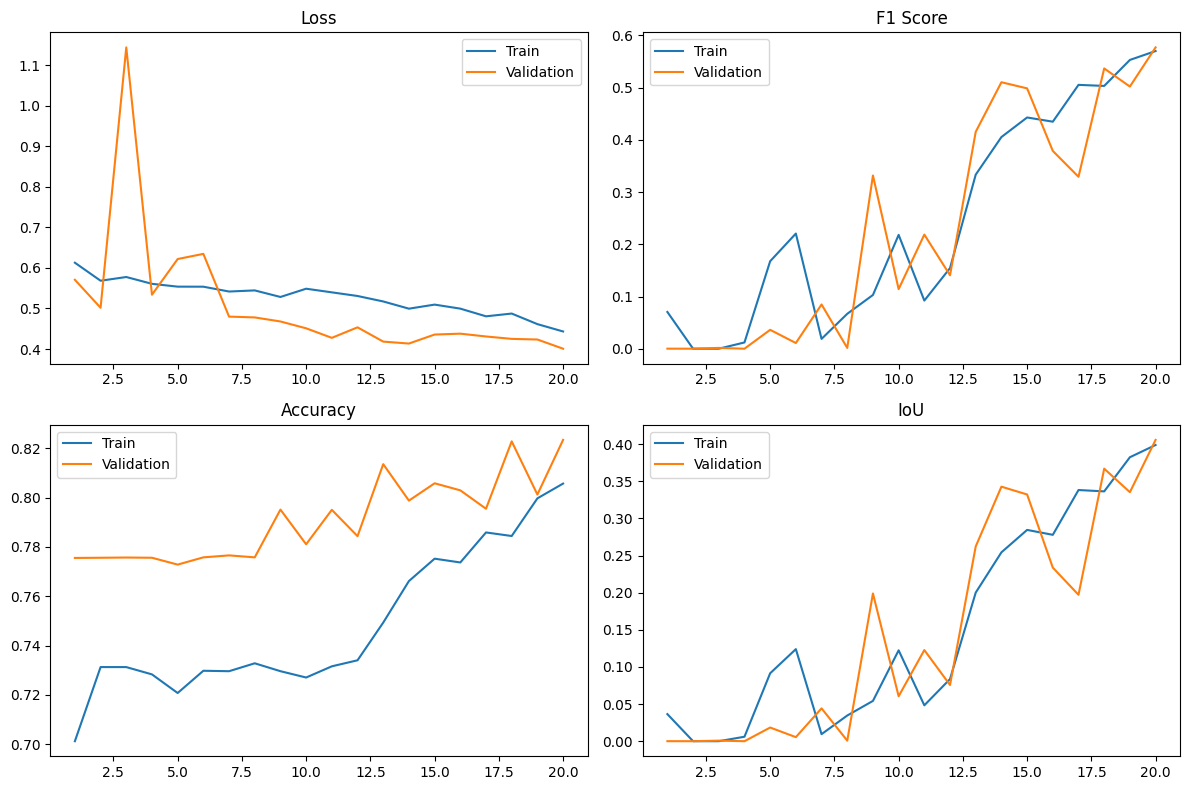

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, jaccard_score
from sklearn.model_selection import train_test_split
import pandas as pd
import segmentation_models_pytorch as smp
from PIL import Image
import torch.nn.functional as F

# ==== Dataset ====

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_files=None, label_files=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.target_size = target_size  # (height, width)
        
        if image_files is not None and label_files is not None:
            self.images = image_files
            self.labels = label_files
        else:
            # Get all image files
            image_extensions = ['.tif', '.tiff', '.png', '.jpg', '.jpeg']
            self.images = sorted([f for f in os.listdir(image_dir) 
                                if any(f.lower().endswith(ext) for ext in image_extensions)])
            
            # Get all label files
            label_extensions = ['.tif', '.tiff', '.png']
            self.labels = sorted([f for f in os.listdir(label_dir) 
                                if any(f.lower().endswith(ext) for ext in label_extensions)])
        
        if len(self.images) == 0:
            raise ValueError(f"No image files found in {image_dir}")
        if len(self.labels) == 0:
            raise ValueError(f"No label files found in {label_dir}")
        if len(self.images) != len(self.labels):
            raise ValueError(f"Number of images ({len(self.images)}) doesn't match number of labels ({len(self.labels)})")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.label_dir, self.labels[idx])

        try:
            # Try reading with tifffile first, fallback to PIL
            try:
                image = tifffile.imread(img_path)
            except:
                image = np.array(Image.open(img_path))
        except Exception as e:
            raise RuntimeError(f"Error reading image file {img_path}: {e}")

        # Handle different image formats
        if image.ndim == 2:
            image = image[np.newaxis, ...]  # (1, H, W)
        elif image.ndim == 3:
            if image.shape[2] in [1, 3, 4]:  # (H, W, C)
                image = np.transpose(image, (2, 0, 1))  # (C, H, W)
            # If already (C, H, W), keep as is

        image = image.astype(np.float32)
        # Normalize to [0, 1] if values are in [0, 255] range
        if image.max() > 1.0:
            image = image / 255.0
        
        # Convert to tensor for resizing
        image_tensor = torch.tensor(image)
        print(f"Original image shape: {image_tensor.shape}")
        
        # Resize image to target size
        image_tensor = F.interpolate(
            image_tensor.unsqueeze(0), 
            size=self.target_size, 
            mode='bilinear', 
            align_corners=False
        ).squeeze(0)
        
        # Standardize after resizing
        image_tensor = (image_tensor - image_tensor.mean()) / (image_tensor.std() + 1e-8)

        try:
            # Try reading with tifffile first, fallback to PIL  
            try:
                mask = tifffile.imread(mask_path)
            except:
                mask = np.array(Image.open(mask_path))
        except Exception as e:
            raise RuntimeError(f"Error reading mask file {mask_path}: {e}")

        # Handle mask format
        if mask.ndim == 3:
            if mask.shape[2] > 1:
                mask = mask[:, :, 0]  # Use first channel if RGB
            else:
                mask = mask.squeeze(-1)  # Remove channel dim if shape is (H, W, 1)

        # Binarize mask and ensure it's float32
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        
        # Convert to tensor and resize mask to target size
        mask_tensor = torch.tensor(mask)
        print(f"Original mask shape: {mask_tensor.shape}")
        
        mask_tensor = F.interpolate(
            mask_tensor.unsqueeze(0), 
            size=self.target_size, 
            mode='nearest'  # Use nearest for masks to preserve binary values
        ).squeeze(0)
        
        # Ensure mask is still binary after resizing
        mask_tensor = (mask_tensor > 0.5).float()
        
        print(f"Final image shape: {image_tensor.shape}")
        print(f"Final mask shape: {mask_tensor.shape}")
        print("-" * 40)

        return image_tensor, mask_tensor

# ==== Metrics ====

def compute_metrics(preds, targets):
    preds_bin = (preds > 0.5).float().cpu().numpy().ravel()
    targets_bin = targets.cpu().numpy().ravel()
    f1 = f1_score(targets_bin, preds_bin, zero_division=1)
    acc = accuracy_score(targets_bin, preds_bin)
    iou = jaccard_score(targets_bin, preds_bin, zero_division=1)
    return f1, acc, iou

# ==== Training ====

def train_fn(loader, model, loss_fn, optimizer, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)

        preds = model(data)
        loss = loss_fn(preds, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_preds.append(preds.detach())
        all_targets.append(targets.detach())

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    f1, acc, iou = compute_metrics(all_preds, all_targets)

    return total_loss / len(loader), f1, acc, iou

# ==== Validation ====

def val_fn(loader, model, loss_fn, device):
    model.eval()
    total_loss, all_preds, all_targets = 0, [], []

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)

            preds = model(data)
            loss = loss_fn(preds, targets)
            total_loss += loss.item()

            all_preds.append(preds.detach())
            all_targets.append(targets.detach())

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    f1, acc, iou = compute_metrics(all_preds, all_targets)

    return total_loss / len(loader), f1, acc, iou

# ==== Main ====

def main():
    # === Config ===
    base_path = r'D:\Cellula_tech_intern\Week4\data'
    image_dir = os.path.join(base_path, 'images')
    label_dir = os.path.join(base_path, 'labels')
    lr = 1e-3
    batch_size = 2
    epochs = 20
    target_size = (256, 256)  # (height, width) - resize all images/masks to this size
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Using device: {device}")
    print(f"Target image size: {target_size}")

    # === Check if directories exist ===
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(label_dir):
        raise FileNotFoundError(f"Label directory not found: {label_dir}")

    # === Create full dataset to determine input channels ===
    full_dataset = SegmentationDataset(image_dir, label_dir, target_size=target_size)
    sample_img, sample_mask = full_dataset[0]
    in_channels = sample_img.shape[0]
    
    print(f"Dataset size: {len(full_dataset)}")
    print(f"Input channels: {in_channels}")
    print(f"Final image shape: {sample_img.shape}")
    print(f"Final mask shape: {sample_mask.shape}")

    # === Train/Validation Split ===
    indices = list(range(len(full_dataset)))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    
    # Get corresponding filenames for train and validation
    train_images = [full_dataset.images[i] for i in train_indices]
    train_labels = [full_dataset.labels[i] for i in train_indices]
    val_images = [full_dataset.images[i] for i in val_indices]
    val_labels = [full_dataset.labels[i] for i in val_indices]
    
    # Create separate datasets
    train_dataset = SegmentationDataset(image_dir, label_dir, train_images, train_labels, target_size)
    val_dataset = SegmentationDataset(image_dir, label_dir, val_images, val_labels, target_size)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # === Data Loaders ===
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # === Load pretrained U-Net model ===
    # Handle different input channels
    if in_channels == 1:
        # For single channel, we'll modify the first conv layer
        model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,  # Start with 3 channels
            classes=1,
            activation="sigmoid"
        )
        # Modify first conv layer for single channel input
        model.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize with average of original weights
        with torch.no_grad():
            original_weight = model.encoder.conv1.weight.data
            model.encoder.conv1.weight.data = original_weight.mean(dim=1, keepdim=True)
    else:
        model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=1,
            activation="sigmoid"
        )
    
    model = model.to(device)
    
    # === Loss and Optimizer ===
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # === Training Loop ===
    logs = []
    best_val_iou = 0.0
    
    for epoch in range(epochs):
        # Training
        train_loss, train_f1, train_acc, train_iou = train_fn(train_loader, model, loss_fn, optimizer, device)
        
        # Validation
        val_loss, val_f1, val_acc, val_iou = val_fn(val_loader, model, loss_fn, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou:.4f}")
        print(f"Val   - Loss: {val_loss:.4f} | F1: {val_f1:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou:.4f}")
        print("-" * 80)
        
        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), "best_unet_model.pth")
            print(f"New best model saved with IoU: {val_iou:.4f}")
        
        logs.append({
            'epoch': epoch+1, 
            'train_loss': train_loss, 'train_f1': train_f1, 'train_acc': train_acc, 'train_iou': train_iou,
            'val_loss': val_loss, 'val_f1': val_f1, 'val_acc': val_acc, 'val_iou': val_iou
        })

    # === Save Logs and Final Model ===
    pd.DataFrame(logs).to_csv("training_log.csv", index=False)
    torch.save(model.state_dict(), "final_unet_model.pth")
    
    print(f"\nTraining complete!")
    print(f"Best validation IoU: {best_val_iou:.4f}")
    print("Model and logs saved.")
    
    # === Plot training curves ===
    df = pd.DataFrame(logs)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Loss
    axes[0,0].plot(df['epoch'], df['train_loss'], label='Train')
    axes[0,0].plot(df['epoch'], df['val_loss'], label='Validation')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()
    
    # F1 Score
    axes[0,1].plot(df['epoch'], df['train_f1'], label='Train')
    axes[0,1].plot(df['epoch'], df['val_f1'], label='Validation')
    axes[0,1].set_title('F1 Score')
    axes[0,1].legend()
    
    # Accuracy
    axes[1,0].plot(df['epoch'], df['train_acc'], label='Train')
    axes[1,0].plot(df['epoch'], df['val_acc'], label='Validation')
    axes[1,0].set_title('Accuracy')
    axes[1,0].legend()
    
    # IoU
    axes[1,1].plot(df['epoch'], df['train_iou'], label='Train')
    axes[1,1].plot(df['epoch'], df['val_iou'], label='Validation')
    axes[1,1].set_title('IoU')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()